# Modules

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Functions

In [2]:
def create_kegg_graph(data_df, include_reactions = True):
    
    G = nx.MultiDiGraph()  # At first create multigraph, later it can be converted
    
    unique_entries = []  # List of unique entries. Each gene, ompound, etc needs to be stored as 1 node
    
    # Iterate data to create all nodes
    for index, entry in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and entry['link type']=='reaction':
            continue            
        
        # -- Handle node for Head --
        n1 = entry['head id']
        if n1 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n1)
            
            #Add node n1
            G.add_node(n1)
            # Assign node type
            if n1[0:3] == 'hsa':
                t = 'gene'
            elif n1[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n1.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['head full name'] == '':
                full_name = n1
            else:
                full_name = entry['head full name']
            pathway = str(entry['pathway'])
            attr = {n1: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n1]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n1]['pathways'] = temp

        # -- Handle node for Tail --
        n2 = entry['tail id']
        if n2 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n2)
            
            #Add node n2
            G.add_node(n2)
            # Assign node type
            if n2[0:3] == 'hsa':
                t = 'gene'
            elif n2[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n2.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['tail full name'] == '':
                full_name = n2
            else:
                full_name = entry['tail full name']
            pathway = str(entry['pathway'])
            attr = {n2: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n2]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n2]['pathways'] = temp
        
        
     # Iterate data to find all relations           
    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and row['link type']=='reaction':
            continue 
        
        head = str(row['head id'])
        tail = str(row['tail id'])
        pathway = str(row['pathway'])
        link_type = str(row['link type'])
        rel_name = str(row['relation name'])
        if head in G.nodes and tail in G.nodes:
            G.add_edge(head, tail,pathway = pathway, link_type= link_type, relation_name= rel_name)
        else:
            print('node not found @row'+str(index))
        
    return G
    

def merge_same_named(G):
    keep = []
    merge = []
    merged_list = []
    for node1 in tqdm(G.nodes):
        for node2 in G.nodes:
            if node1 != node2:
                if G.nodes[node1]['full name'] == G.nodes[node2]['full name']:
                    merged_list.append("Merge: "+node1+" + "+node2+ " as "+G.nodes[node1]['full name'])
                    # Prefer to merge glycan as compound
                    if node1[0:3] == 'cpd':
                        keep.append(node1)
                        merge.append(node2)
                    else:
                        keep.append(node2)
                        merge.append(node1)
                        
    for n1,n2 in zip(keep,merge):
        if n1 in G.nodes and n2 in G.nodes:
            G = nx.contracted_nodes(G,n1,n2)
            
    
    return G, merged_list 

# Exploratory Data Analysis

In [3]:
# === load data ===
df_relations = pd.read_csv('../KEGG Pathways Dataset Collection/All_relations-Curated-full_names-test2.csv')
G_directed = create_kegg_graph(df_relations)
print(G_directed)
G_undirected = nx.Graph(G_directed)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████| 17448/17448 [00:01<00:00, 13291.90it/s]


MultiDiGraph with 5187 nodes and 17448 edges
Graph with 5187 nodes and 11804 edges


In [4]:
# Merge some double occurrences of compounds as glycans
G_directed,mld = merge_same_named(G_directed)
print(G_directed)
G_undirected,mlu = merge_same_named(G_undirected)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████████| 5187/5187 [00:46<00:00, 111.84it/s]


MultiDiGraph with 5165 nodes and 17448 edges


100%|█████████████████████████████████████████████████████████████████████████████| 5187/5187 [00:44<00:00, 117.02it/s]


Graph with 5165 nodes and 11791 edges


In [5]:
lst = []
for c in sorted(nx.connected_components(G_undirected), key=len, reverse=True):
    lst.append(len(c))
print("Number of connected components: "+str(len(lst)))
print("\nNumber of nodes in each component:")
print(lst)

Number of connected components: 158

Number of nodes in each component:
[4810, 7, 7, 7, 6, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
# Keep main component only. Prevent biased zeros to unconnected nodes
largest_cc = max(nx.connected_components(G_undirected), key=len)
lsmain = list(largest_cc)

G_undirected_main = G_undirected.copy()
G_directed_main = G_directed.copy()
remove = []
for node in G_undirected_main.nodes:
    if node not in lsmain:
        remove.append(node)
        
for node in remove:        
    G_undirected_main.remove_node(node)
    G_directed_main.remove_node(node)
        
print(G_directed_main)
print(G_undirected_main)

MultiDiGraph with 4810 nodes and 17205 edges
Graph with 4810 nodes and 11577 edges


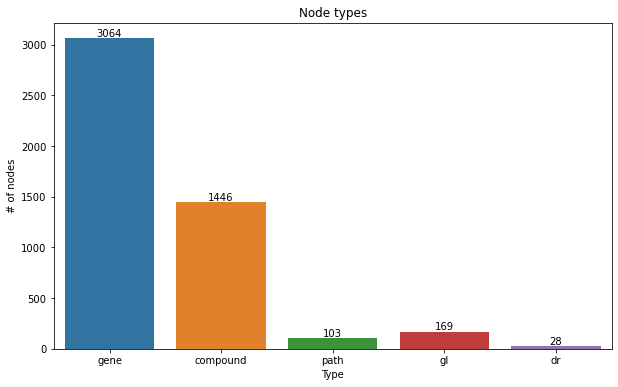

In [7]:
# === node types ===
# Node types are the same for Directed and Undirected
types = list(nx.get_node_attributes(G_directed_main, 'type').values())
plt.figure(figsize=(10,6))
plt.title("Node types")
ax = sns.countplot(x=types)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Type", ylabel = "# of nodes")
plt.show()

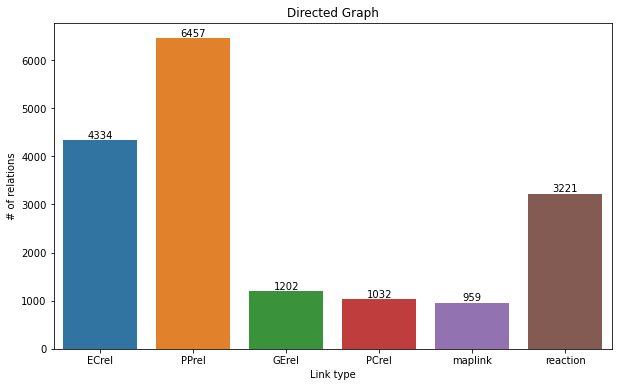

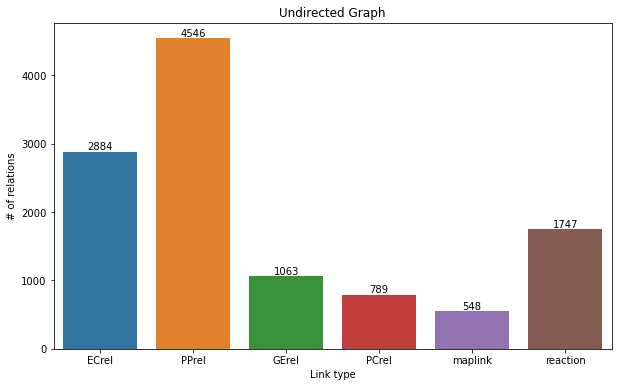

In [8]:
# === link types ===

# Directed graph
plt.figure(figsize=(10,6))
edge_list = list(G_directed_main.edges(data=True))
links_list = []
for edge in edge_list:
    links_list.append(edge[2]['link_type'])
ax = sns.countplot(x=links_list, order = ["ECrel", "PPrel", "GErel","PCrel", "maplink", "reaction"])
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Link type", ylabel = "# of relations", title = "Directed Graph")
plt.show()

# Undirected graph
plt.figure(figsize=(10,6))
edge_list = list(G_undirected_main.edges(data=True))
links_list = []
for edge in edge_list:
    links_list.append(edge[2]['link_type'])
ax = sns.countplot(x=links_list, order = ["ECrel", "PPrel", "GErel","PCrel", "maplink", "reaction"])
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Link type", ylabel = "# of relations", title = "Undirected Graph")
plt.show()

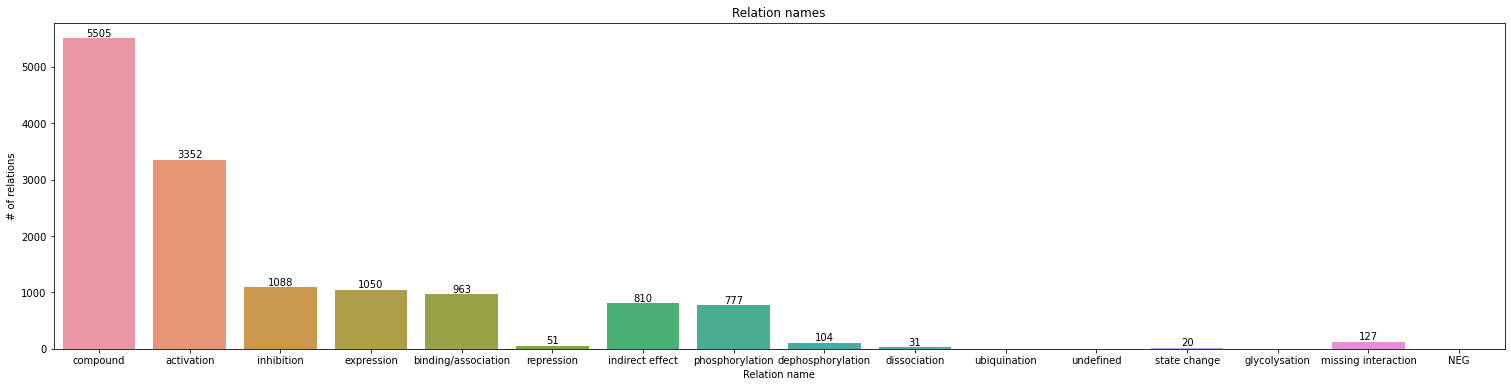

In [9]:
# relation names in Directed Graph
lst = df_relations['relation name'].to_list()
plt.figure(figsize=(26,6))
ax = sns.countplot(x=lst, order = ["compound", "activation","inhibition", "expression", "binding/association", "repression", 
                                   "indirect effect", "phosphorylation", "dephosphorylation","dissociation","ubiquination", 
                                   "undefined","state change", "glycolysation", "missing interaction", "NEG"])
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Relation name", ylabel = "# of relations", title = "Relation names")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 4810/4810 [00:15<00:00, 302.08it/s]


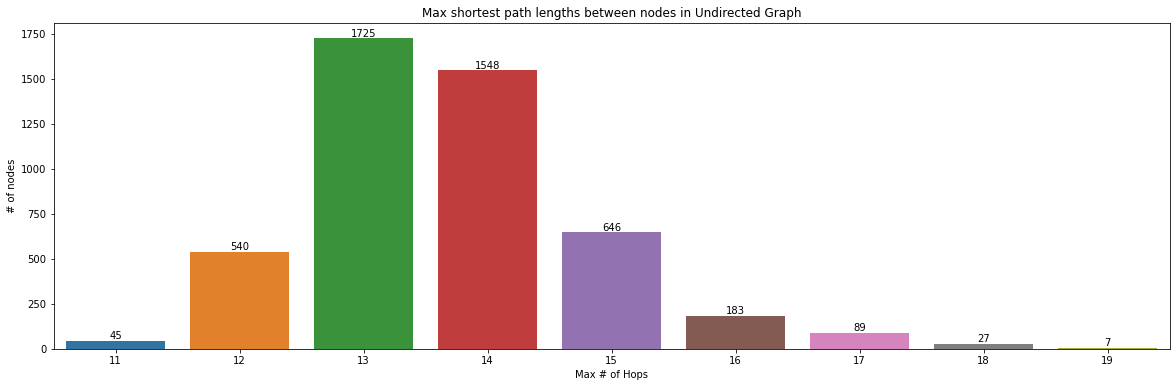

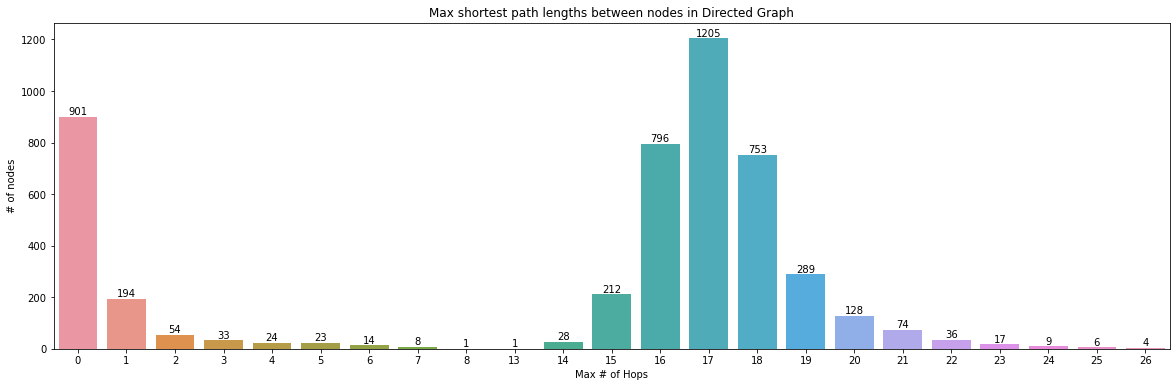

In [10]:
# Find max shortest path lengths between nodes 

# Undirected Graph
spls = nx.shortest_path_length(G_undirected_main)
lengths = []
for source_node in tqdm(spls, total = len(G_undirected_main.nodes)):
    lengths.append(max(list(source_node[1].values())))
    
plt.figure(figsize=(20,6))
ax = sns.countplot(x=lengths)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Max # of Hops", ylabel = "# of nodes", title = "Max shortest path lengths between nodes in Undirected Graph")
plt.draw()   


# Directed Graph
spls = nx.shortest_path_length(G_directed_main)
lengths = []
for source_node in tqdm(spls, total = len(G_directed_main.nodes)):
    lengths.append(max(list(source_node[1].values())))
    
plt.figure(figsize=(20,6))
ax = sns.countplot(x=lengths)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Max # of Hops", ylabel = "# of nodes", title = "Max shortest path lengths between nodes in Directed Graph")
plt.draw()  

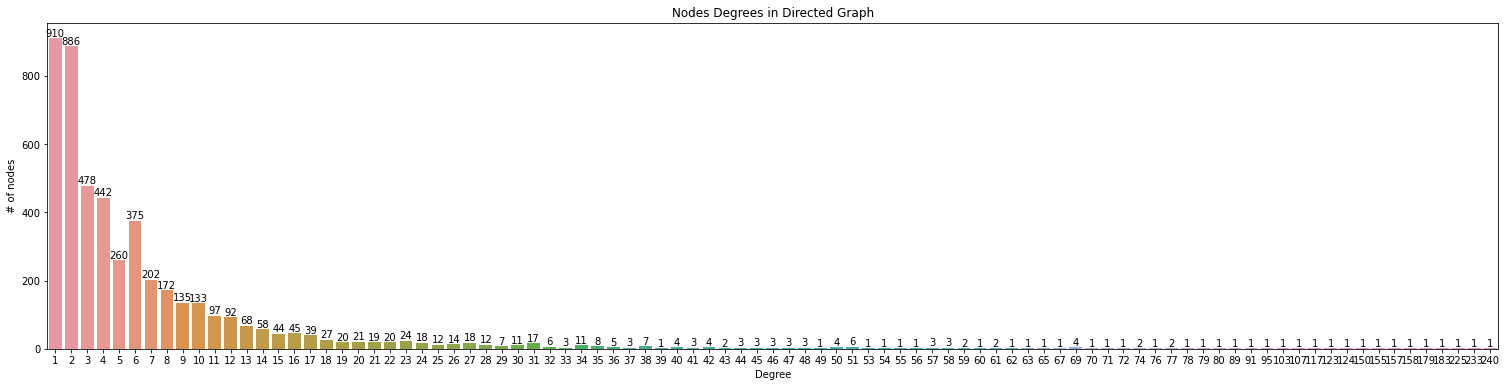

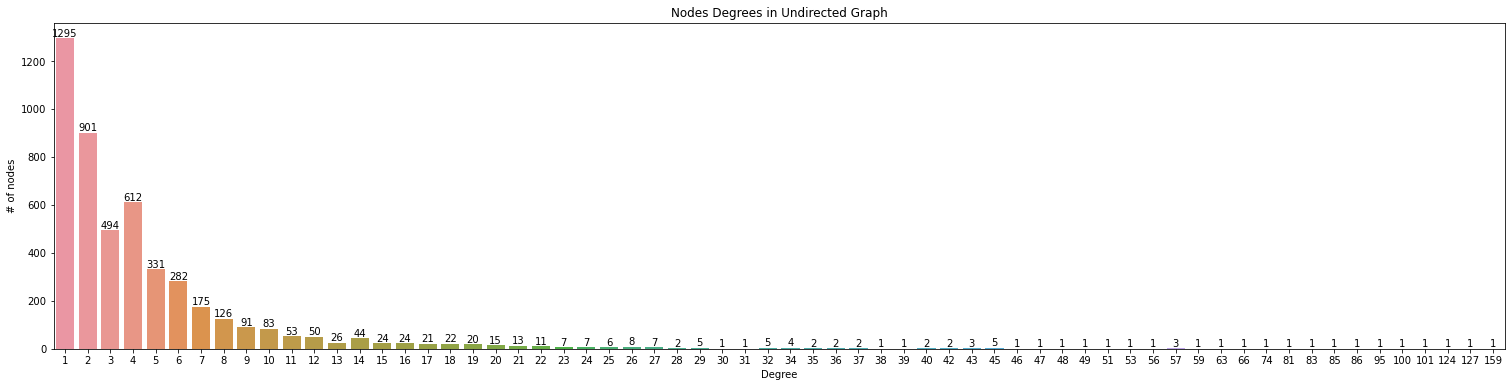

In [11]:
# Degrees for nodes in Directed Graph
degrees = []

for node in G_directed_main.nodes:
    degrees.append(G_directed_main.degree[node])
        
        
plt.figure(figsize=(26,6))
ax = sns.countplot(x=degrees)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Degree", ylabel = "# of nodes", title = "Nodes Degrees in Directed Graph")
plt.draw()

# Degrees for nodes in Undirected Graph
degrees = []

for node in G_undirected_main.nodes:
    degrees.append(G_undirected_main.degree[node])
        
        
plt.figure(figsize=(26,6))
ax = sns.countplot(x=degrees)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Degree", ylabel = "# of nodes", title = "Nodes Degrees in Undirected Graph")
plt.draw()

# Krebs Cycle Represantation

MultiDiGraph with 36 nodes and 183 edges
Graph with 36 nodes and 71 edges


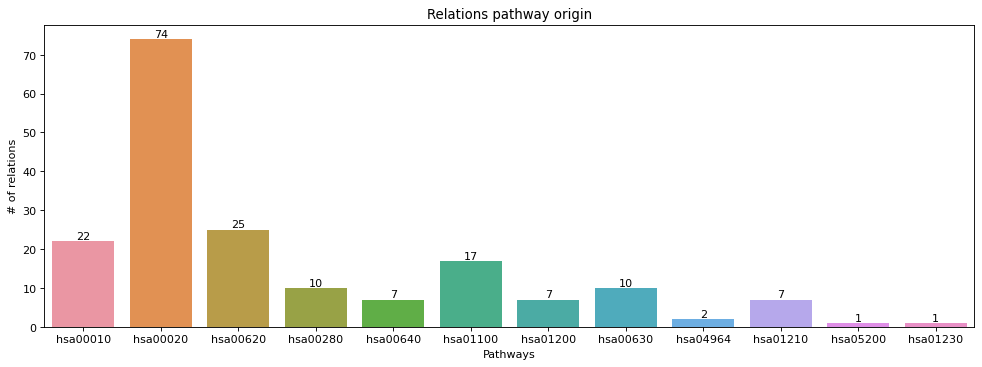

In [12]:
# --------------------------- Krebs Cycle Represantation -------------------------- #
G_Krebs = G_directed.copy()

for node in G_directed.nodes():
    if G_directed.nodes[node]["type"] == 'path':
        G_Krebs.remove_node(node)
        continue
    if 'hsa00020' not in G_directed.nodes[node]["pathways"]:
        G_Krebs.remove_node(node)
        
print(G_Krebs)
G_Krebs_undirected = G_undirected.copy()

for node in G_undirected.nodes():
    if G_undirected.nodes[node]["type"] == 'path':
        G_Krebs_undirected.remove_node(node)
        continue
    if 'hsa00020' not in G_undirected.nodes[node]["pathways"]:
        G_Krebs_undirected.remove_node(node)
print(G_Krebs_undirected)

edge_list = list(G_Krebs.edges(data=True))
paths_list = []
for edge in edge_list:
    paths_list.append(edge[2]['pathway'])

plt.figure(figsize=(15,5), dpi=80)
ax = sns.countplot(x=paths_list)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Pathways", ylabel = "# of relations", title = "Relations pathway origin")
plt.show()


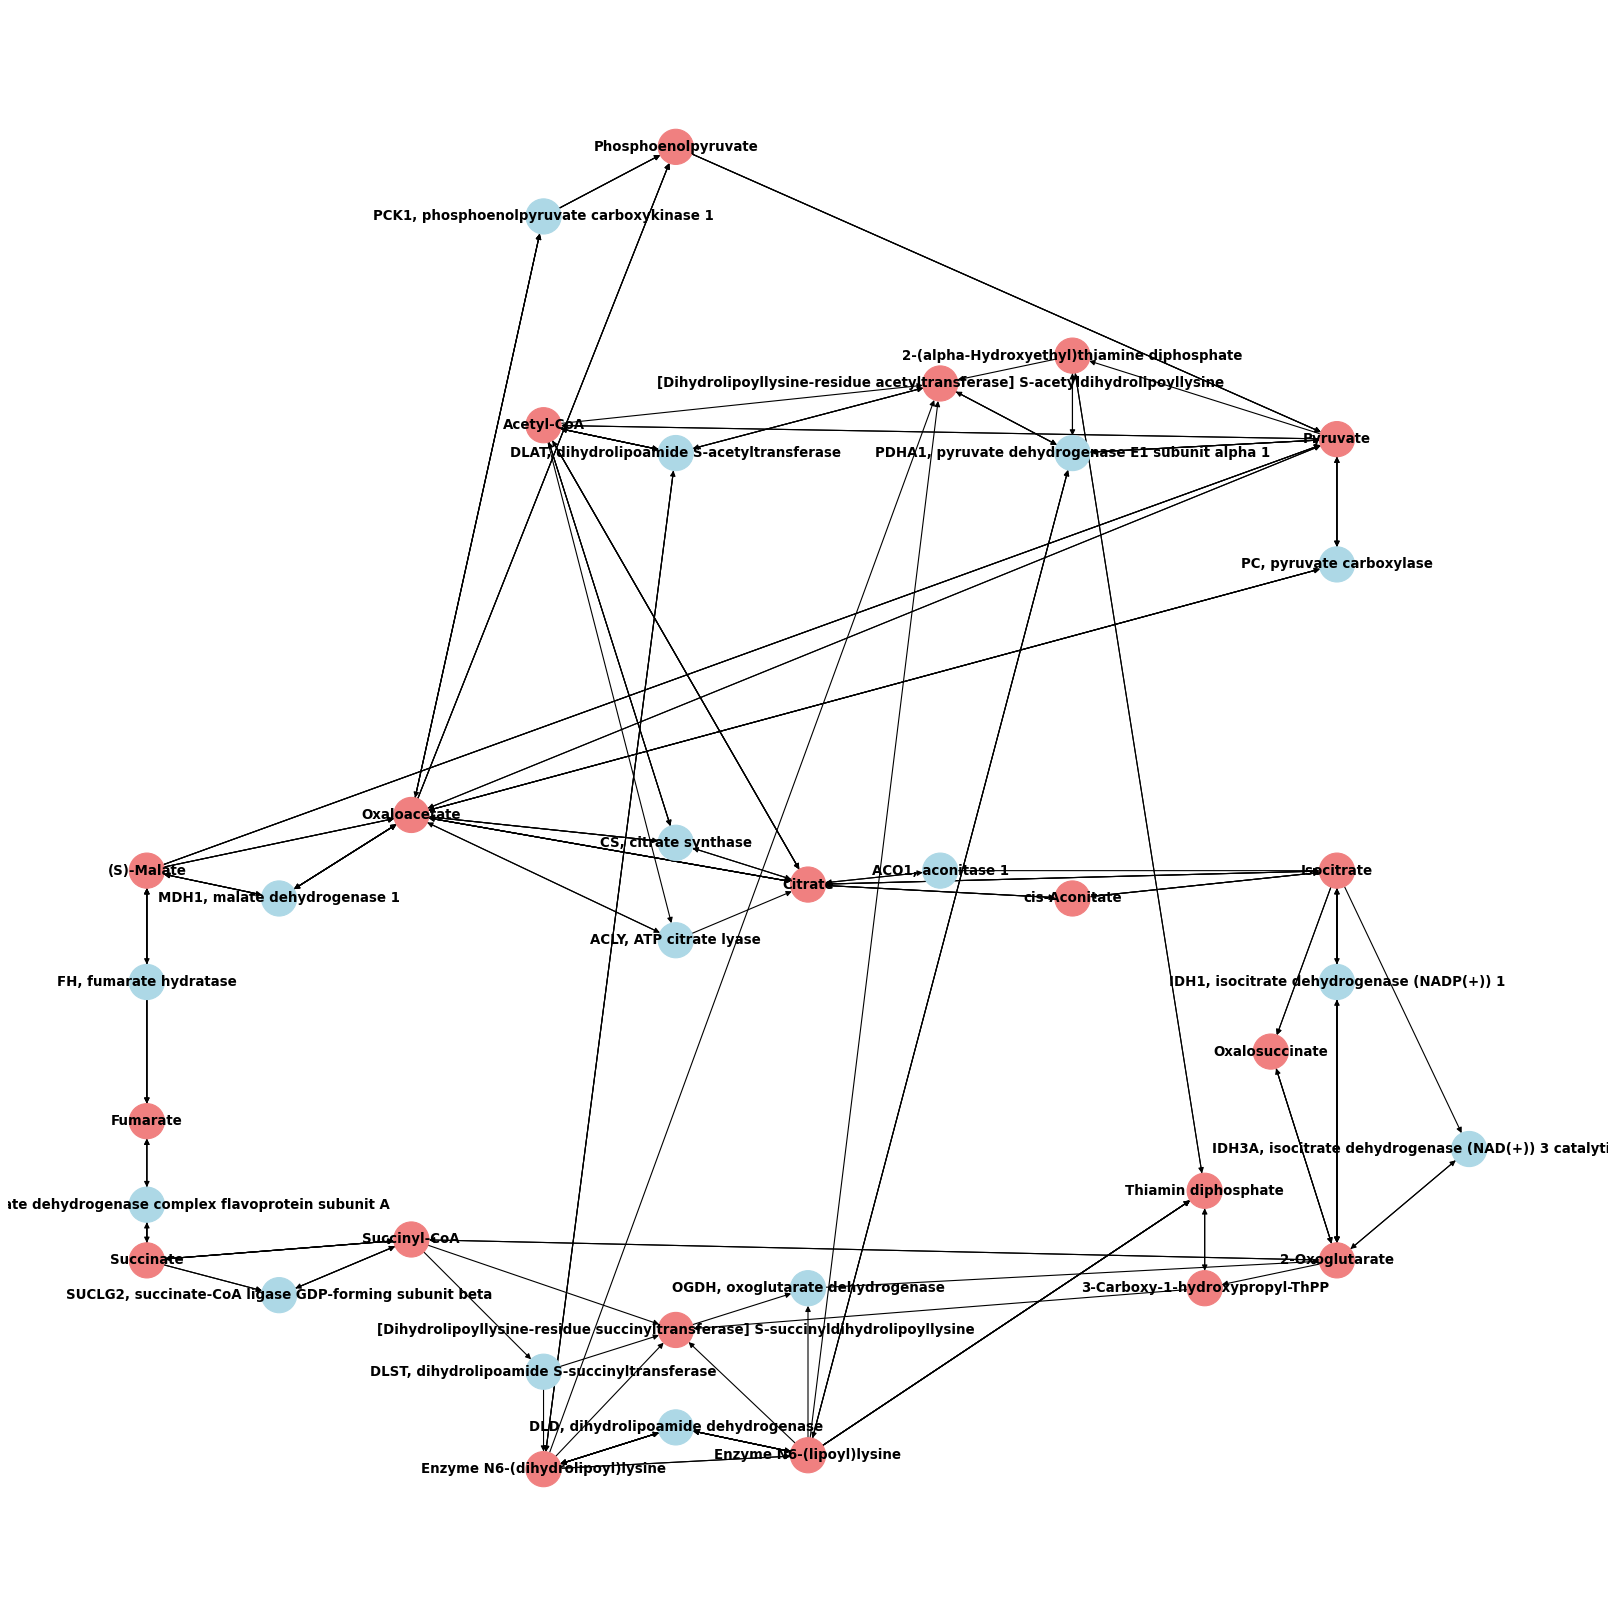

In [13]:
# Plot the Graph with custom positions  
custom_pos = {'hsa:5105': [-0.1, 0.45],
 'hsa:1431': [0, 0],
 'hsa:47':[0,  -0.07],
#  'citrate (Re)-synthase':[0,  -0.04], # Not human
 'hsa:48': [0.2, -0.02],
 'hsa:3417': [ 0.5, -0.1],
#  'isocitrate---homoisocitrate dehydrogenase':  ([ 0.6, -0.2]), # Not human
 'hsa:3419':  ([ 0.6, -0.22]),
#  '2-oxoacid oxidoreductase (ferredoxin)':  ([0.1,  -0.52]),  # Not human
#  '2-oxoglutarate synthase':  ([0.1,  -0.5]),  # Not human
 'hsa:4967':  ([0.1, -0.32]),
 'hsa:1738':  ([0,  -0.42]),
 'hsa:1743':  ([-0.1,  -0.38 ]),
 'hsa:8802':  ([-0.3, -0.28]),  # Not in the dataset because it was in the same entry as hsa:8801!
 'hsa:8801':  ([-0.3, -0.325]),
#  'succinyl-CoA:acetate CoA-transferase':  ([-0.3, -0.32]),  # Not human
 'hsa:6389':  ([-0.4,  -0.26]),
 'hsa:2271':  ([-0.4, -0.1]),
#  'fumarate hydratase (quionol)':  ([-0.4, -0.1]),  # Not human
#  'malate dehydrogenase (quinone)':  ([ -0.3, 0.0]),  # Not human
 'hsa:4190':  ([ -0.3, -0.04]),
 'hsa:5091':  ([ 0.5, 0.2]),
 'hsa:5160':  ([0.3, 0.28]),
 'hsa:1737':  ([0,  0.28]),
 'cpd:C00024':  ([-0.1, 0.3]),
 'cpd:C00158':  ([0.1, -0.03]),
 'cpd:C00417':  ([0.3, -0.04]),
 'cpd:C00311':  ([ 0.5, -0.02]),
 'cpd:C05379':  ([0.45, -0.15]),
 'cpd:C00026':  ([0.5, -0.3]),
 'cpd:C05381' :  ([0.4, -0.32]), 
 'cpd:C00068':  ([0.4, -0.25]),
 'cpd:C16254':  ([0,  -0.35]),
 'cpd:C00091':  ([-0.2, -0.285]),
 'cpd:C16255':  ([0.2, 0.33]),
 'cpd:C15973':  ([-0.1,  -0.45]),
 'cpd:C15972':  ([ 0.1, -0.44]),
 'cpd:C00042':  ([-0.4 , -0.3]),
 'cpd:C00122':  ([ -0.4 , -0.2]),
 'cpd:C00149':  ([ -0.4, -0.02]),
 'cpd:C00036':  ([-0.2, 0.02]),
 'cpd:C00022':  ([ 0.5, 0.29]),
 'cpd:C05125':  ([0.3, 0.35]),
 'cpd:C16275':  ([0.1,  0.3]),
 'cpd:C00074':  ([0,  0.5])}


plt.figure(figsize=(20,20), dpi=80)
labels = nx.get_node_attributes(G_Krebs, 'full name') 
color_map = []
for node in G_Krebs:
    if node[0:3]=='hsa':
        color_map.append('lightblue')
    else: 
        color_map.append('lightcoral') 
nx.draw(G_Krebs,labels=labels,node_size=1000, pos = custom_pos, node_color = color_map,font_weight='bold')